### Krill Growth Model (Atkinson et al 2006)

#### This empirical model derives a Daily Growth Rate (DGR, mm $d^{-1}$) from a starting length of an individual krill, chlorophyll concentration, and SST:

$DGR = a + b * Length + c * Length^2 + [d * \frac{CHL}{e + CHL}] + f * SST + g * SST ^2$

- Length (L mm) = Proxy for growth =  using 40mm as the starting value (observed mean length of adult krill)
- SST (°C) = Proxy for survival =  threshold between -1 to 5°C
- Chl-a (mg m$^{-3}$) = Proxy for food availability - threshold: 0.5 mg m-3
___
a = -0.066 #alpha
b = 0.002 #beta
c = -0.000061 #gamma
d = 0.385 #delta
e = 0.328 #epsilon
f = 0.0078 #zeta
g = -0.0101 #eta

### Objective: estimate the growth potential for each 1° by 1° latitude-longitude grid cell for each month (mm month−1)

From Murphy et al 2017:
<blockquote> Growth potential was calculated in two ways. In the first we calculated growth rates for each month only for months and cells where both SST and chlorophyll a values were present. In the second calculation for the months and locations where SST data were available but chlorophyll data were missing, we assumed the chlorophyll a concentration was 0.0 mg m−3 . Area-weighted mean growth rates were derived to generate summary estimates of circumpolar mean monthly growth rates (September to April; May to August were excluded because of extensive missing data due to cloud and sea ice cover). To calculate individual growth curves at specific localities, we undertook linear interpolation of the monthly (1° spatially resolved) values to derive estimates of daily SST and chlorophyll a. Equation 1 was applied iteratively to calculate daily growth rate (mm d−1 ). Calculations were initiated when SST and chlorophyll a values were both first available after the 1 st September. When there was no chlorophyll a estimate available later in the season a concentration of 0.0 mg chl a m −3 was assumed. </blockquote>

### Notebook Goal: 
#### write a function to calculate KGP in the same dimensions of an ensemble member:

example:

<code>def compute KGP(CHL, SST):
    return f(CHL) + g(SST)   
</code>
so that `KGP = compute_KGP(CHL, SST)` #inherits dims of chl and sst (member_id, time, nlat, nlon) and so that you can go further to do `KGP_SO = compute_areal_mean(KGP)` resulting in KGP_SO dims = m, t, region


In [1]:
#Import Modules
import math
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import exp
%matplotlib inline

In [7]:
# DGR Equation: dgr = a + (b*l_i) + (c*l_i**2) + ((d*chl) / 
#                      (e+chl)) + (f*sst) + (g*sst**2) + l_i
# Set Constants
a = -0.066 #alpha
b = 0.002 #beta
c = -0.000061 #gamma
d = 0.385 #delta
e = 0.328 #epsilon
f = 0.0078 #zeta
g = -0.0101 #eta

In [ ]:
def compute_KGP(CHL, SST, start_len):
    ''' Calculates Krill Growth Potential from Chl-a and SST data
    Input: chl and sst arrays (with the same dimensions)
    Additional input: a starting length
    Steps:
    1. Generate a krill_length array with dims matching CHL and SST 
        1a. for time = 0,9,18,27....etc (or for month = 10 of each year),
            populate the array with the start_len input
        1b. the rest of the values for each time point are nans and will be
            calculated by the function 
    2. SST is masked to only values within krill survival thresholds
        yeilding a viable habitat range (vhab)
            DO THIS FOR EACH MONTH of the spring/winter/and fall seasons
    3. CHL is masked to SST mask yeilding a viable growth habitat range (vgrow)
            DO THIS FOR EACH MONTH of the spring/winter/and fall seasons
    4. Use the DGR equation with the vhab(time=0), vgrow(time=0),
        and krill_length(time=0) to calculate krill_length(time=1);
    5. Iterate step 4 for every timestep of an annual cycle (sp/sum/fall); 
    6. Keep iterating step 5, but reset to 'start'
    
    Returns the following arrays, all with the same dims as the input arrays:
        a) viable habitat range (vhab)
        b) viable growth habitat range (vgrow)
        c) krill length array
    
     '''

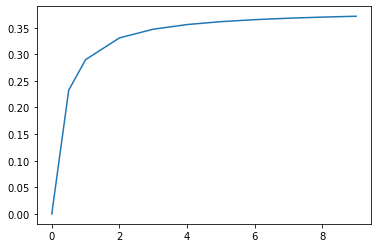

In [63]:
#Plotting Chlorophyll independently
chl = np.array([0,0.5,1,2,3,4,5,6,7,8,9])
y = (d*chl) / (e+chl)

plt.plot(chl, y)

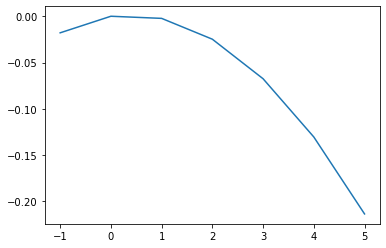

In [64]:
#Plotting SST independently
sst = np.array([-1,0,1,2,3,4,5])
eq = (f*sst) + (g*sst**2)

plt.plot(sst, eq)

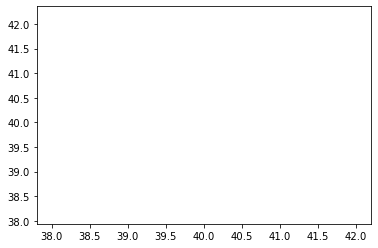

In [72]:
l_i = 40
chl = chl = np.array([0,0.5,1,2,3,4,5,6,7,8,9])
sst = np.array([-1,0,1,2,3,4,5])
dgr = a + (b*l_i) + (c*l_i**2) + ((d*chl) / (e+chl)) + (f*sst) + (g*sst**2)+l_i

plt.plot(l_i, dgr)

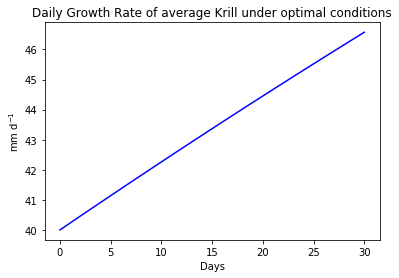

In [10]:
# Example of Model Using Optimal Conditions
# Set starting length
L = [40] #this is a list
sst = -1 #example temp within optimal range
chl = 2 #example chl within optimal range

#lists to reference t for computing t+1 quantities
for i in range(30): 
    Lnew = a + (b*L[i]) + (c*L[i]**2) + ((d*chl) / (e+chl)) + (f*sst) + (g*sst**2) + L[i]
    #append calculated new value to old value (list)
    L.append(Lnew) #appends list
    
# Plot results
plt.plot(L,color = "blue")
plt.title('Daily Growth Rate of average Krill under optimal conditions')
plt.ylabel('mm d$^{-1}$'); plt.xlabel('Days')
plt.show()

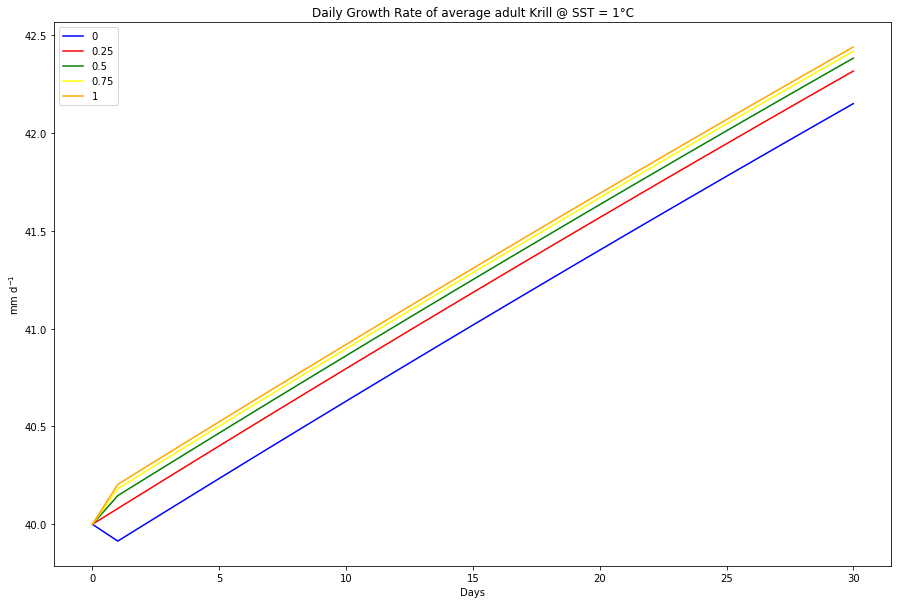

In [36]:
# Example of Model Using Optimal Conditions
# Set starting length
L = [40] #this is a list
L2 = [40] #this is a list
L3 = [40] #this is a list
L4 = [40] #this is a list
L0 = [40] #this is a list
sst = 1 #example temp within optimal range
chl0 = 0 #example chl within optimal range
chl = 0.25 #example chl within optimal range
chl2 = 0.5 #example chl within optimal range
chl3 = 0.75 #example chl within optimal range
chl4 = 1 #example chl within optimal range

#lists to reference t for computing t+1 quantities
for i in range(30): 
    Lnew = a + (b*L[i]) + (c*L[i]**2) + ((d*chl) / (e+chl)) + (f*sst) + (g*sst**2) + L[i]
    #append calculated new value to old value (list)
    L.append(Lnew) #appends list
    
#lists to reference t for computing t+1 quantities
for i in range(30): 
    Lnew2 = a + (b*L[i]) + (c*L[i]**2) + ((d*chl2) / (e+chl2)) + (f*sst) + (g*sst**2) + L[i]
    #append calculated new value to old value (list)
    L2.append(Lnew2) #appends list
    
#lists to reference t for computing t+1 quantities
for i in range(30): 
    Lnew3 = a + (b*L[i]) + (c*L[i]**2) + ((d*chl3) / (e+chl3)) + (f*sst) + (g*sst**2) + L[i]
    #append calculated new value to old value (list)
    L3.append(Lnew3) #appends list
    
#lists to reference t for computing t+1 quantities
for i in range(30): 
    Lnew4 = a + (b*L[i]) + (c*L[i]**2) + ((d*chl4) / (e+chl4)) + (f*sst) + (g*sst**2) + L[i]
    #append calculated new value to old value (list)
    L4.append(Lnew4) #appends list
    
#lists to reference t for computing t+1 quantities
for i in range(30): 
    Lnew0 = a + (b*L[i]) + (c*L[i]**2) + ((d*chl0) / (e+chl0)) + (f*sst) + (g*sst**2) + L[i]
    #append calculated new value to old value (list)
    L0.append(Lnew0) #appends list
    
# Plot results
fig = plt.figure(figsize=(15, 10))

plt.plot(L0, color = "blue", label = '0')
plt.plot(L, color = "red", label = '0.25')
plt.plot(L2, color = "green", label = '0.5')
plt.plot(L3, color = "yellow", label = '0.75')
plt.plot(L4, color = "orange", label = '1')
plt.legend()
plt.title('Daily Growth Rate of average adult Krill @ SST = 1°C')
plt.ylabel('mm d$^{-1}$'); plt.xlabel('Days')
plt.show()


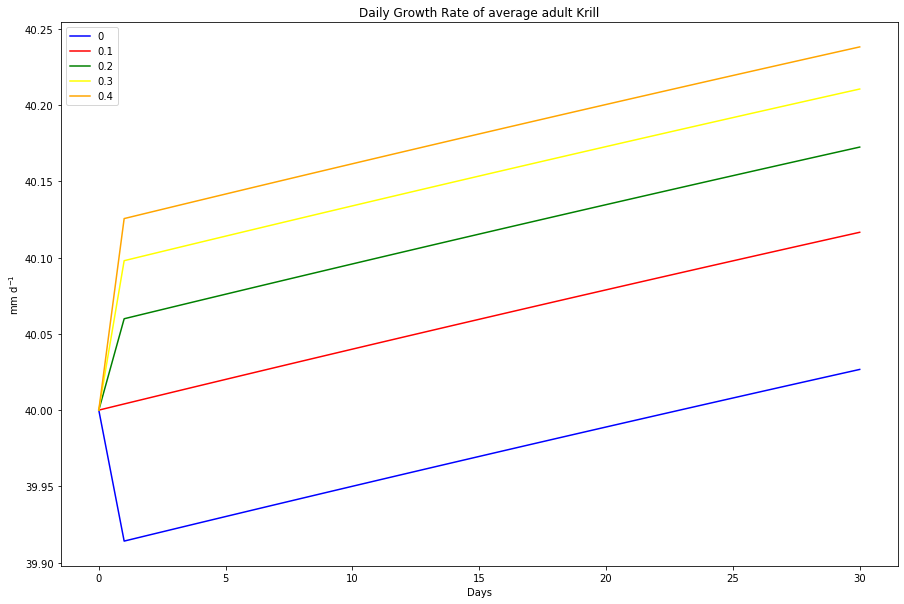

In [33]:
# Example of Model Using Optimal Conditions
# Set starting length
L = [40] #this is a list
L2 = [40] #this is a list
L3 = [40] #this is a list
L4 = [40] #this is a list
L0 = [40] #this is a list
sst = 1 #example temp within optimal range
chl0 = 0 #example chl within optimal range
chl = 0.1 #example chl within optimal range
chl2 = 0.2 #example chl within optimal range
chl3 = 0.3 #example chl within optimal range
chl4 = 0.4 #example chl within optimal range

#lists to reference t for computing t+1 quantities
for i in range(30): 
    Lnew = a + (b*L[i]) + (c*L[i]**2) + ((d*chl) / (e+chl)) + (f*sst) + (g*sst**2) + L[i]
    #append calculated new value to old value (list)
    L.append(Lnew) #appends list
    
#lists to reference t for computing t+1 quantities
for i in range(30): 
    Lnew2 = a + (b*L[i]) + (c*L[i]**2) + ((d*chl2) / (e+chl2)) + (f*sst) + (g*sst**2) + L[i]
    #append calculated new value to old value (list)
    L2.append(Lnew2) #appends list
    
#lists to reference t for computing t+1 quantities
for i in range(30): 
    Lnew3 = a + (b*L[i]) + (c*L[i]**2) + ((d*chl3) / (e+chl3)) + (f*sst) + (g*sst**2) + L[i]
    #append calculated new value to old value (list)
    L3.append(Lnew3) #appends list
    
#lists to reference t for computing t+1 quantities
for i in range(30): 
    Lnew4 = a + (b*L[i]) + (c*L[i]**2) + ((d*chl4) / (e+chl4)) + (f*sst) + (g*sst**2) + L[i]
    #append calculated new value to old value (list)
    L4.append(Lnew4) #appends list
    
#lists to reference t for computing t+1 quantities
for i in range(30): 
    Lnew0 = a + (b*L[i]) + (c*L[i]**2) + ((d*chl0) / (e+chl0)) + (f*sst) + (g*sst**2) + L[i]
    #append calculated new value to old value (list)
    L0.append(Lnew0) #appends list
    
# Plot results
fig = plt.figure(figsize=(15, 10))

plt.plot(L0, color = "blue", label = '0')
plt.plot(L, color = "red", label = '0.1')
plt.plot(L2, color = "green", label = '0.2')
plt.plot(L3, color = "yellow", label = '0.3')
plt.plot(L4, color = "orange", label = '0.4')
plt.legend()
plt.title('Daily Growth Rate of average adult Krill')
plt.ylabel('mm d$^{-1}$'); plt.xlabel('Days')
plt.show()


In [39]:
((d*chl0) / (e+chl0))

0.232487922705314